In [1]:
%reload_ext autoreload
%autoreload 2   
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import RandomSearch, HyperModel, Hyperband, HyperParameters
from tensorflow.keras.callbacks import EarlyStopping

from DataEncoder import encode_pad_event, encode_pad_sequence, encode_y
from BaseLSTMIm import BaseLSTMModel,print_best_hp
from utils import plot_training_history_LSTMim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
event = pd.read_csv("D:/Research in UAE/sequence/output/Event_Feature_pro.csv")
sequence = pd.read_csv("D:/Research in UAE/sequence/output/Sequence_Feature_pro.csv")

In [3]:
y_col = sequence.result
y_encode = encode_y(y_col)

In [4]:
cat_col_event = ['Activity_verb', 'Activity_Dec', 'Resource', 'outcome', "stopcode"]
num_col_event = ['net_promotor_score', 'creditscore', 'rate_charged', 'duration']
case_index = 'Case ID'

event_encode = encode_pad_event(event, cat_col_event, num_col_event, case_index, cat_mask = True, num_mask = True, eos = False)

In [5]:
cat_col_seq = ['plan']
num_col_seq = ['age', 'coverage_numeric', 'length_of_stay']
sequence_encode = encode_pad_sequence(sequence, cat_col_seq, num_col_seq)

In [6]:
# Define the input shape (sequence_length, number_of_features)
event_input_shape = (event_encode.shape[1], event_encode.shape[2])

# Define the number of classes 
num_classes = y_encode.shape[1]

# number of sequence features
num_sequence_features = sequence_encode.shape[1]

In [7]:
# Include batch size as a hyperparameter to be tuned
hp_b = HyperParameters()
batch_size = hp_b.Choice('batch_size', values=[16, 32, 64, 128])

In [8]:
# Split indices for train and test
train_indices, test_indices = train_test_split(np.arange(len(y_encode)), test_size=0.2, stratify=y_encode, random_state=42)

# Split the data
train_event_features = event_encode[train_indices]
test_event_features = event_encode[test_indices]

train_sequence_features = sequence_encode[train_indices]
test_sequence_features = sequence_encode[test_indices]

train_y = y_encode[train_indices]
test_y = y_encode[test_indices]

In [9]:
#Initialize the hypermodel
hypermodel = BaseLSTMModel(event_input_shape=event_input_shape,
                           num_sequence_features= num_sequence_features,
                           num_classes=num_classes)

In [35]:
early_stopping = EarlyStopping(monitor='val_f1_score',  
                               mode='max',
                               patience=5, 
                               restore_best_weights=True)
tuner_band = Hyperband(hypermodel,
                       objective=kt.Objective("val_f1_score", direction="max"),
                       max_epochs=200,
                       factor=3,
                       directory='hparam_tuning',
                       overwrite=False, #if resume tuner, keep overwrite = False
                       project_name='classfication_2levelfeature_hyperband_im',
                       hyperparameters=hp_b)

# Use the manually split data in the search
tuner_band.search(x=[train_event_features, train_sequence_features], y=train_y, 
                  validation_data=([test_event_features, test_sequence_features], test_y), 
                  epochs=200, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps_band = tuner_band.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model_band = tuner_band.get_best_models(num_models=1)[0]


Trial 254 Complete [00h 00m 32s]
val_f1_score: 0.6499903202056885

Best val_f1_score So Far: 0.8655925393104553
Total elapsed time: 01h 30m 43s


In [36]:
# Get predictions
y_pred_probs = best_model_band.predict([test_event_features, test_sequence_features])
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
y_true = np.argmax(test_y, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute Classification Report
class_report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(class_report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Confusion Matrix:
[[ 92   0   0   0   0   0]
 [  0 174   0   0   0   0]
 [  0   0   5   0   0   0]
 [  0   0   0  21   0   0]
 [  0   4   0   0  28   0]
 [  0  45   0   0   4  55]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        92
           1     0.7803    1.0000    0.8766       174
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000        21
           4     0.8750    0.8750    0.8750        32
           5     1.0000    0.5288    0.6918       104

    accuracy                         0.8762       428
   macro avg     0.9425    0.9006    0.9072       428
weighted avg     0.9013    0.8762    0.8656       428



In [10]:
early_stopping = EarlyStopping(monitor='val_f1_score',  
                               mode='max',
                               patience=5, 
                               restore_best_weights=True)
tuner_band = Hyperband(hypermodel,
                       objective=kt.Objective("val_f1_score", direction="max"),
                       max_epochs=200,
                       factor=3,
                       directory='hparam_tuning',
                       overwrite=False, #if resume tuner, keep overwrite = False
                       project_name='classfication_2levelfeature_hyperband_im',
                       hyperparameters=hp_b)

# Get the optimal hyperparameters
best_hps_band = tuner_band.get_best_hyperparameters(num_trials=1)[0]
print_best_hp(best_hps_band)


Reloading Tuner from hparam_tuning\classfication_2levelfeature_hyperband_im\tuner0.json
Best hyperparameters found were:
Number of LSTM layers: 2
  LSTM Layer 0:
    Units: 160
    Dropout Rate: 0.4913845777963388
    L2 Regularization: 0.00019634218681491059
    Batch Norm Momentum: 0.81
    Batch Norm Epsilon: 0.00033459755475717326
  LSTM Layer 1:
    Units: 48
    Dropout Rate: 0.3156053994179221
    L2 Regularization: 0.0004419772860765411
Number of Dense layers: 1
  Dense Layer 0:
    Units: 144
    Activation: relu
    Dropout Rate: 0.4581934322370699
    L2 Regularization: 0.0002007819160434203
Optimizer: rmsprop
  Learning Rate (RMSprop): 0.0027179521580834405
Learning Rate Schedule: piecewise_constant
Best batch size: 32


Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - f1_score: 0.8175 - loss: 0.4673 - val_f1_score: 0.8610 - val_loss: 0.4081
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - f1_score: 0.8296 - loss: 0.4098 - val_f1_score: 0.8436 - val_loss: 0.4136
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - f1_score: 0.8407 - loss: 0.4060 - val_f1_score: 0.8716 - val_loss: 0.3458
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - f1_score: 0.8499 - loss: 0.3781 - val_f1_score: 0.8480 - val_loss: 0.4096
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - f1_score: 0.8395 - loss: 0.3952 - val_f1_score: 0.8440 - val_loss: 0.4360
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - f1_score: 0.8158 - loss: 0.4562 - val_f1_score: 0.8489 - val_loss: 0.3961
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - f1_score: 0.8294 - loss: 0.3903 - val_f1_score: 0.8494 - val_loss: 0.3911
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - f1_score: 0.8370 - loss: 0.4043 - val_f1_score: 0.

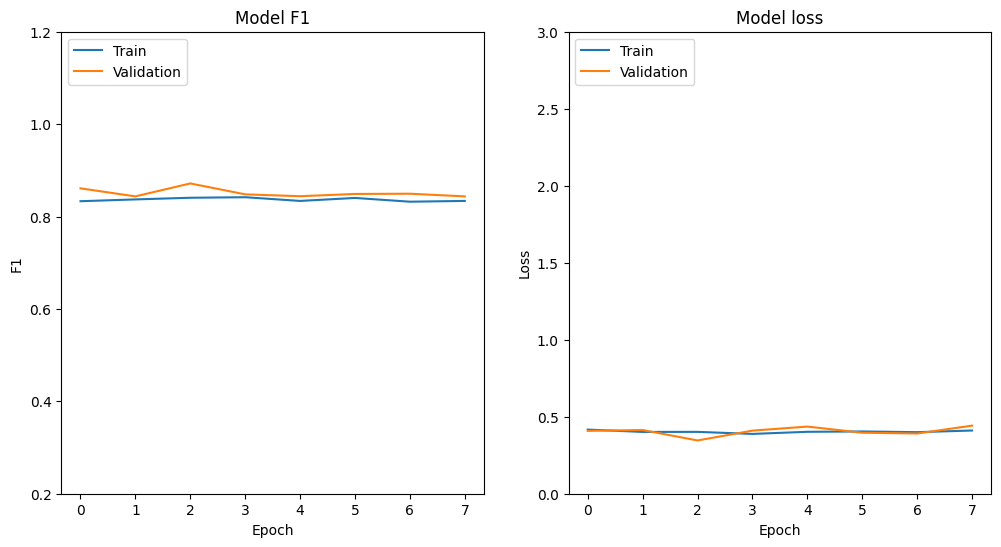

In [37]:

# alternatively, build the model with the optimal hyperparameters 
# best_model_band  = band_tuner.hypermodel.build(best_hps_band)
history_band = best_model_band.fit(x=[train_event_features, train_sequence_features], y=train_y, 
                                   validation_data=([test_event_features, test_sequence_features], test_y), 
                                   epochs=200, batch_size=best_hps_band.get('batch_size'), callbacks=[early_stopping])

#print(history_band.history.keys())  

val_acc_per_epoch_band = history_band.history['val_f1_score']
best_epoch_band = val_acc_per_epoch_band.index(max(val_acc_per_epoch_band)) + 1
print('Best epoch: %d' % (best_epoch_band,))
print('Best F1 Score: ', max(val_acc_per_epoch_band))
# Evaluate the best model
#loss, accuracy = best_model_band.evaluate([event_encode, sequence_encode],y_encode)
#print('Test accuracy:', accuracy)

plot_training_history_LSTMim(history_band.history)

In [22]:
# RandomSearch
tuner_rand= RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='hparam_tuning',
    project_name='classfication_2levelfeatures_rand',
    hyperparameters=hp_b
)

tuner_rand.search(x=[event_encode, sequence_encode], y = y_encode,\
             epochs=300, validation_split=0.2, callbacks=[early_stopping])

# Get the best models and hyperparameters after search is randed
best_model_rand = tuner_rand.get_best_models(num_models=1)[0]
best_hps_rand = tuner_rand.get_best_hyperparameters(num_trials=1)[0]

# Fit the best model with the optimal batch size
best_model_rand.fit(
    [event_encode, sequence_encode],
    y_encode,
    epochs=300,
    batch_size=best_hps_rand.get('batch_size'),  # Use the best batch size found
    validation_split=0.2
)

# Evaluate the best model
loss, accuracy = best_model_rand.evaluate([event_encode, sequence_encode], y_encode)
print('Test accuracy:', accuracy)
print_best_hp(best_hps_rand)
#print_best_hp(best_hps)
best_model_rand.summary()

Reloading Tuner from hparam_tuning\classfication_2levelfeatures_rand\tuner0.json

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
128               |16                |batch_size
3                 |2                 |num_lstm_layers
240               |48                |lstm_units_l0
3.1668e-05        |0.00049681        |l2_reg_l0
True              |True              |use_batch_norm_l0
0.4403            |0.34583           |dropout_l0
2                 |3                 |num_dense_layers
16                |144               |dense_units_0
0.0006438         |1.244e-05         |l2_dense_0
tanh              |softmax           |dense_activation_0
0.54881           |0.1019            |dropout_dense_0
inverse_time      |polynomial        |lr_schedule_type
0.00017534        |0.00077456        |init_lr
sgd               |adam              |optimizer
0.88              |0.89              |adam_beta_1
0.993             |0.991             |adam_beta_2
0.11           

KeyboardInterrupt: 

In [10]:
def create_combined_lstm_model(event_input_shape, num_sequence_features, num_classes, lstm_units=128, dropout_rate = 0.2):
    
    """
    Create and compile an LSTM model for classification.
    
    Parameters:
    - event_input_shape: Tuple representing the shape of the input data (sequence_length, number_of_features).
    - num_sequence_features: Interger represnting the number of sequence level feature
    - num_classes: Integer representing the number of target classes.
    - lstm_units: Integer representing the number of units in LSTM layers.
    - dropout_rate: Float between 0 and 1 representing the dropout rate for regularization.
    
    Returns:
    - Compiled Keras model ready for training.
    """    
    # Event-level input: Sequential data for LSTM processing
    event_input = Input(shape= event_input_shape, name='event_input')
    x = Masking(mask_value=-1.0)(event_input)
    # LSTM layers processing event-level features
    #lstm0_out = LSTM(lstm_units, return_sequences=True)(event_input)
    lstm0_out = LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(0.02))(x)
    lstm0_out = Dropout(dropout_rate)(lstm0_out)
    #lstm1_out = LSTM(int(lstm_units / 2), return_sequences=True)(lstm0_out)
    #lstm1_out = Dropout(dropout_rate)(lstm1_out)
    # Additional LSTM layer
    #lstm_out = LSTM(int(lstm_units / 2), return_sequences=False, kernel_regularizer=l2(0.02))(lstm0_out)  # Set return_sequences=False on the last LSTM layer
    #lstm_out = Dropout(dropout_rate)(lstm_out)

    # Sequence-level input: Static context features for the whole sequence
    sequence_input = Input(shape=(num_sequence_features,), name='sequence_input')

    # Concatenate LSTM output with sequence-level features
    concatenated = Concatenate()([lstm0_out, sequence_input])

    # Dense layer(s) after concatenation
    dense0_out = Dense(lstm_units, activation='relu', kernel_regularizer=l2(0.02))(concatenated)
    dense0_out = Dropout(dropout_rate)(dense0_out)
    #dense1_out = Dense(int(lstm_units/2), activation='relu')(dense0_out)  # Additional dense layer
    #dense1_out = Dropout(dropout_rate)(dense1_out)
    #dense_out = Dense(int(lstm_units/4), activation='relu')(dense1_out)  # Additional dense layer
    #dense_out = Dropout(dropout_rate)(dense_out)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(dense0_out)

    # Build and compile the model
    model = Model(inputs=[event_input, sequence_input], outputs=output)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
model = create_combined_lstm_model(event_input_shape, num_sequence_features, num_classes, lstm_units=128, dropout_rate=0.2)
history = model.fit([event_encode, sequence_encode],y_encode, epochs=300, batch_size=32, validation_split=0.2)

Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4318 - loss: 4.6529 - val_accuracy: 0.6900 - val_loss: 2.4580
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6885 - loss: 2.1477 - val_accuracy: 0.7156 - val_loss: 1.5327
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7109 - loss: 1.4372 - val_accuracy: 0.7319 - val_loss: 1.1705
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7460 - loss: 1.0865 - val_accuracy: 0.7273 - val_loss: 0.9935
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7509 - loss: 0.9184 - val_accuracy: 0.7319 - val_loss: 0.9173
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7333 - loss: 0.8681 - val_accuracy: 0.7226 - val_loss: 0.8793
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7561 - loss: 0.8180 - val_accuracy: 0.7319 - val_loss: 0.8336
Epoch 8/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7268 - loss: 0.8201 - val_accuracy: 0.7319 - 

In [21]:
plot_training_history(history)

NameError: name 'history' is not defined

In [ ]:
plot_training_history_smooth(history)